## ENUNCIADO EJERCICIO

* Dataset Airbnb NYC https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data AB_NYC_2019.csv
    * Quitar columnas: id, host_id, host_name
    * Fecha: probar a descomponer la fecha en campos año mes y día con pandas es decir, en 3 columnas, por ejemplo usando to_datetime de pandas y los accesores de fecha para extraer año mes y día.

* EDAs (10%) (menos foco para este módulo)
    * univariantes: histogramas boxplot countplot
    * bivariantes: scatterplot
    * multivariante: corr en heatmap, pairplot
* Preprocesados (20%)
    * numéricas: imputer, scaler, transformer
    * categóricas: imputer, encoder
    * Requisito: hacer los preprocesados con Scikit Learn en lugar de métodos de pandas
* clustering y siluetas (10 %)
    * Crear una columna cluster usando KMeans o cualquier otro algoritmo de Clustering
    * Usar esa columna para hacer algún gráfico EDA como hue para colorear con scatterplot
* feature selection (10%)
    * SelectKBest para filtrar las mejores columnas y probar
    * PCA 
* Regresión (20%):
    * Predecir la columna 'price'
* Clasificación multiclase (20%)
    * Predecir la columna 'room_type'
* Comparar resultados de modelos con validación cruzada (10 %)
    * Mostrar un dataframe de resultados con las métricas calculadas
    * Opcional: mostrar boxplot de los resultados de validación cruzada como tiempos de ejecución y predicción y métricas

* Opcional:
    * Uso de pipelines opcional:
        * Opción 1: hacer las transformaciones por separado manualmente
        * Opción 2: hacer las transformaciones con pipelines
        * Opción 3: una primera parte con transformaciones manuales y una segunda parte con Pipeline
        * En ambos casos sería interesante calcular las métricas para ver qué técnicas de preprocesado van mejor
    * Vectorizar la columna texto 'name' y usar TruncatedSVD
    * Clasificación multiclase 'room_type' o regresión sobre price con TensorFlow-Keras
    * SMOTE si hay desbalanceo para el problema de clasificación multiclase 'room_type'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y preprocesado con Scikit-Learn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (r2_score, mean_absolute_error, accuracy_score, 
                             mean_absolute_percentage_error, 
                             root_mean_squared_error, f1_score, precision_score,
                             recall_score, roc_auc_score, silhouette_score)
from sklearn.svm import SVR
from imblearn.over_sampling import SMOTE                 # Para balanceo de clases en clasificación
from collections import Counter


# Carga datos e investigación del dataset

In [2]:
df = pd.read_csv('airbnb_nyc_clean.csv')
df.head(3)

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,instant_bookable,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,...,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,...,142.0,28.0,13.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,unconfirmed,Elise,Manhattan,Harlem,40.80902,-73.94190,True,...,620.0,124.0,3.0,0.0,2019-06-14,0.79,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and..."


In [3]:
print("=== Información del DataFrame ===")
print(df.info())

=== Información del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              69305 non-null  int64  
 1   name                            69305 non-null  object 
 2   host_id                         69305 non-null  int64  
 3   host_identity_verified          69305 non-null  object 
 4   host_name                       69305 non-null  object 
 5   neighbourhood_group             69305 non-null  object 
 6   neighbourhood                   69305 non-null  object 
 7   lat                             69305 non-null  float64
 8   long                            69305 non-null  float64
 9   instant_bookable                69305 non-null  bool   
 10  cancellation_policy             69305 non-null  object 
 11  room_type                       69305 non-null  object 
 12

* Tratamiento de la fecha: descomponer en año, mes, día

In [4]:
# df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
# df['last_review_year']  = df['last_review'].dt.year
# df['last_review_month'] = df['last_review'].dt.month
# df['last_review_day']   = df['last_review'].dt.day

* Vectorizar la columna name

In [5]:
# # Vectorizar la columna name
# tfidf_vect = TfidfVectorizer()
# X_tfidf_vectorized = tfidf_vect.fit_transform(df['name'])

# # Convertir la matriz a array denso
# tfidf_array = X_tfidf_vectorized.toarray()
# # Obtener los nombres de las características (palabras) del vectorizador
# tfidf_columns = tfidf_vect.get_feature_names_out()
# # Crear un DataFrame con estos datos
# tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf_columns)
# # Concatenar este DataFrame con el original
# df = pd.concat([df, tfidf_df], axis=1)


* Borrado columnas que voy a considerar para este ejercicio, por ahora no relevantes

In [6]:
df = df.drop(['id','name','host_id','host_name','last_review', 'house_rules'], axis=1)
print(df.columns)

Index(['host_identity_verified', 'neighbourhood_group', 'neighbourhood', 'lat',
       'long', 'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


* Busqueda de Nans

In [7]:
df.isna().sum()

host_identity_verified            0
neighbourhood_group               0
neighbourhood                     0
lat                               0
long                              0
instant_bookable                  0
cancellation_policy               0
room_type                         0
construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
review_rate_number                0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

* Análisis de datos numéricos

In [8]:
df.describe()

,lat,long,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
count,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000,69305.000000
mean,40.728070,-73.949036,2012.489503,624.736070,124.894026,4.620330,28.003896,1.301503,3.321636,8.976755,153.184287
std,0.055973,0.050470,5.756144,331.158937,66.222794,4.356887,52.035180,1.659188,1.255746,34.808447,134.421373
min,40.499790,-74.249840,2003.000000,50.000000,10.000000,0.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,40.688540,-73.982790,2008.000000,339.000000,68.000000,2.000000,1.000000,0.300000,2.000000,1.000000,18.000000
50%,40.722650,-73.954390,2012.000000,624.736070,124.894026,3.000000,7.000000,0.790000,3.000000,1.000000,127.000000
75%,40.762730,-73.931380,2017.000000,911.000000,182.000000,6.000000,30.000000,1.730000,4.000000,3.000000,281.000000
max,40.916970,-73.705220,2022.000000,1200.000000,240.000000,13.000000,1024.000000,90.000000,5.000000,332.000000,426.000000


* Análisis de variables a predecir:
    - Price (regresión)
    - Room_type (clasificación)

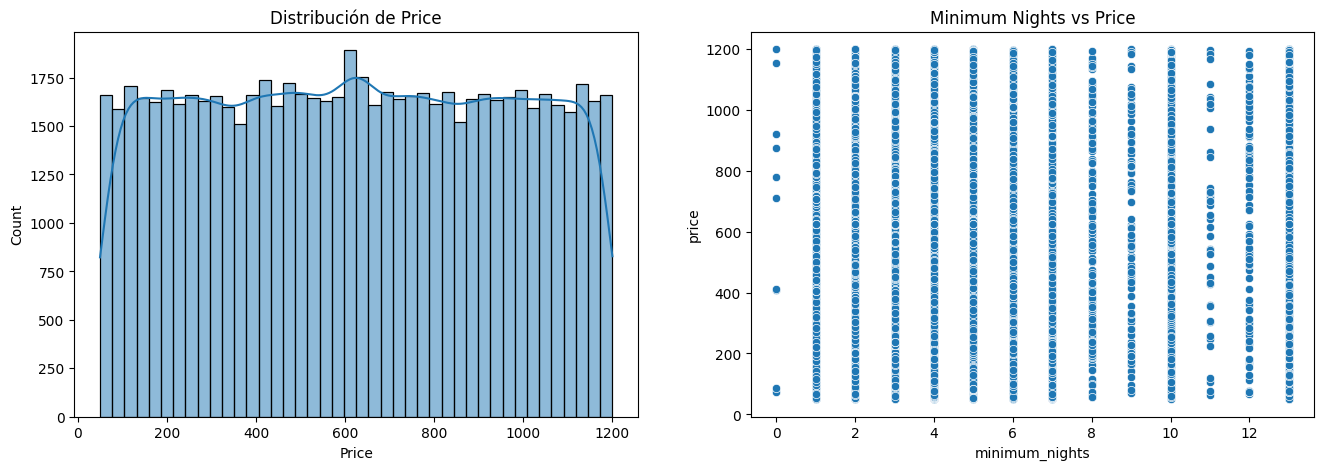

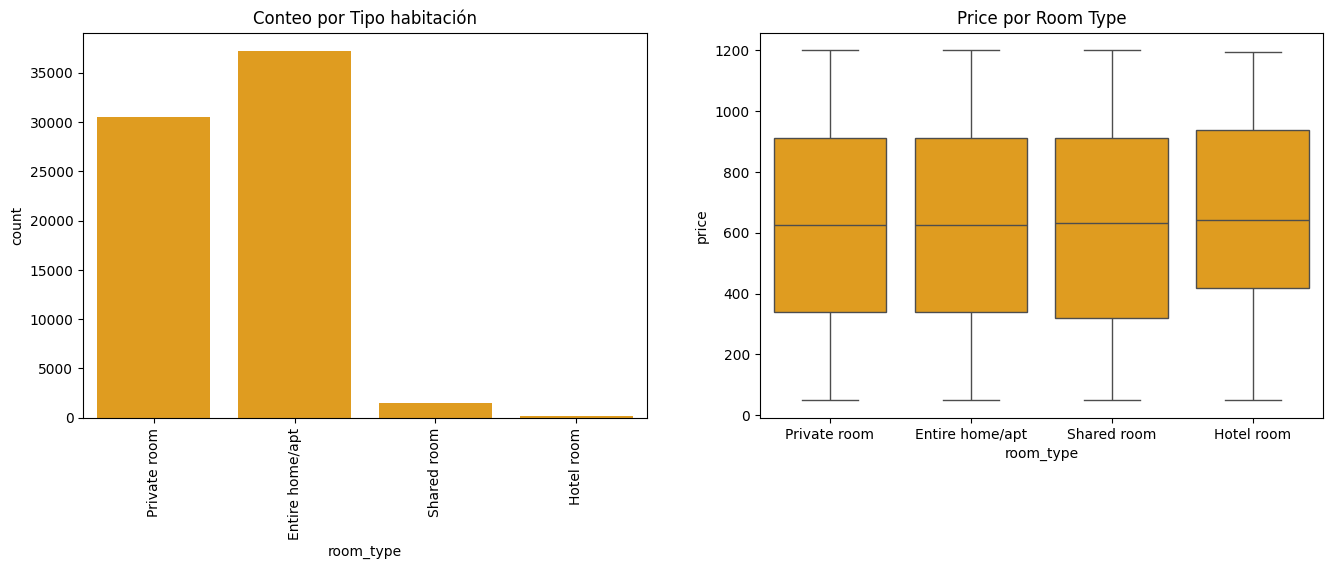

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Distribución de Price')
plt.xlabel('Price')
plt.subplot(1, 2, 2)
sns.scatterplot(x='minimum_nights', y='price', data=df)
plt.title('Minimum Nights vs Price')
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='room_type', data=df, color='orange')
plt.title('Conteo por Tipo habitación')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.boxplot(x='room_type', y='price', data=df, color='orange')
plt.title('Price por Room Type')
plt.show()



# Regresión

* Correlaciones

In [10]:
# Matriz correlación
df.corr(numeric_only=True).round(2)

,lat,long,instant_bookable,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
lat,1.00,0.06,0.0,0.00,-0.00,-0.00,0.04,-0.03,-0.02,-0.00,0.04,-0.00
long,0.06,1.00,-0.0,0.00,0.01,0.00,-0.10,0.06,0.11,0.02,-0.11,0.05
instant_bookable,0.00,-0.00,1.0,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
construction_year,0.00,0.00,0.0,1.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00,-0.00
price,-0.00,0.01,-0.0,-0.00,1.00,1.00,-0.00,0.01,0.01,-0.00,0.00,-0.00
service_fee,-0.00,0.00,0.0,-0.00,1.00,1.00,-0.00,0.01,0.00,-0.00,0.00,-0.00
minimum_nights,0.04,-0.10,-0.0,-0.00,-0.00,-0.00,1.00,-0.13,-0.27,0.02,0.23,0.07
number_of_reviews,-0.03,0.06,0.0,0.00,0.01,0.01,-0.13,1.00,0.55,-0.01,-0.08,0.07
reviews_per_month,-0.02,0.11,-0.0,0.01,0.01,0.00,-0.27,0.55,1.00,0.03,-0.04,0.04
review_rate_number,-0.00,0.02,0.0,0.01,-0.00,-0.00,0.02,-0.01,0.03,1.00,0.02,-0.01


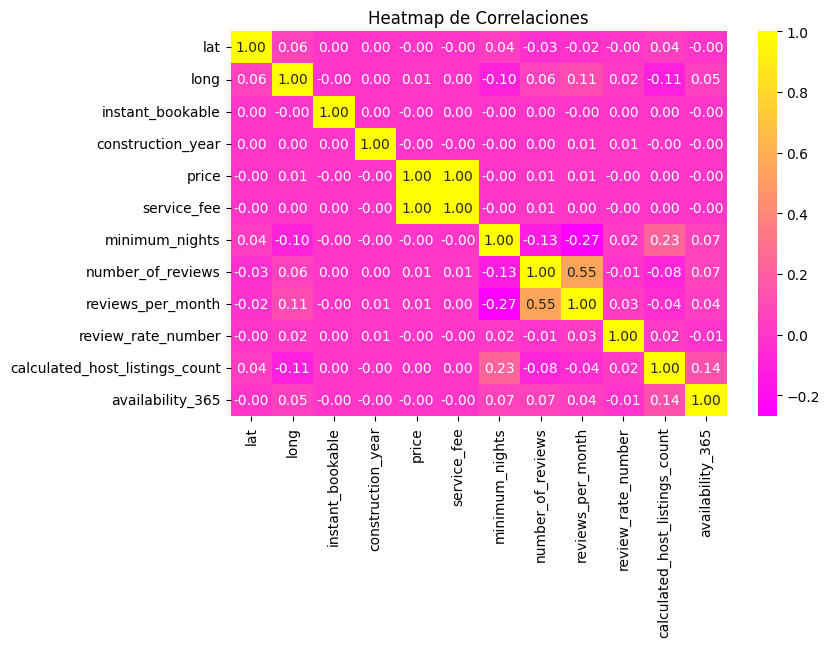

In [11]:
# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(numeric_only=True).round(2), annot=True, cmap='spring', fmt=".2f")
plt.title('Heatmap de Correlaciones')
plt.show()

* Pairplot

In [ ]:
sns.pairplot(df)

## Preprocesamiento

### Imputer (Tratamiento de Nans)

In [ ]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

imputer_num = SimpleImputer(strategy='mean')
df_numerical = imputer_num.fit_transform(df[numerical_cols])

imputer_cat = SimpleImputer(strategy='constant', fill_value='Other')
df_categorical = imputer_cat.fit_transform(df[categorical_cols])

df_categorical_df = pd.DataFrame(df_categorical, columns=categorical_cols, index=df.index)

df_numerical_df = pd.DataFrame(df_numerical, columns=numerical_cols, index=df.index)

df = pd.concat([df_numerical_df, df_categorical_df], axis=1).astype(df.dtypes.to_dict())

print(df.isna().sum())
df.info()


lat                               0
long                              0
construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
review_rate_number                0
calculated_host_listings_count    0
availability_365                  0
host_identity_verified            0
neighbourhood_group               0
neighbourhood                     0
instant_bookable                  0
cancellation_policy               0
room_type                         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lat                             69305 non-null  float64
 1   long                            69305 non-null  float64
 2   construction_year

* Outlier

In [ ]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = filtro = ~((df['price'] < lower_bound) | (df['price'] > upper_bound))
print(df.shape)
print(df[filtro].shape)
#df = df[filtro]


(69305, 17)
(69305, 17)


### Encoder

In [ ]:
df_cla = df.copy()
df_cla.head()

,lat,long,construction_year,price,service_fee,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,host_identity_verified,neighbourhood_group,neighbourhood,instant_bookable,cancellation_policy,room_type
0,40.64749,-73.97237,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0,unconfirmed,Brooklyn,Kensington,False,strict,Private room
1,40.75362,-73.98377,2007.0,142.0,28.0,13.0,45.0,0.38,4.0,2.0,228.0,verified,Manhattan,Midtown,False,moderate,Entire home/apt
2,40.80902,-73.94190,2005.0,620.0,124.0,3.0,0.0,0.79,5.0,1.0,352.0,unconfirmed,Manhattan,Harlem,True,flexible,Private room
3,40.68514,-73.95976,2005.0,368.0,74.0,13.0,270.0,4.64,4.0,1.0,322.0,unconfirmed,Brooklyn,Clinton Hill,True,moderate,Entire home/apt
4,40.79851,-73.94399,2009.0,204.0,41.0,10.0,9.0,0.10,3.0,1.0,289.0,verified,Manhattan,East Harlem,False,moderate,Entire home/apt


In [ ]:
numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns.to_list() # np.number alternativa
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.to_list()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
df_encoded = encoder.fit_transform(df[categorical_columns]) 

df = pd.concat(
    [
        pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out()).reset_index(drop=True), # categoricas
        df[numerical_columns].reset_index(drop=True) # numéricas
    ],
    axis=1
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69305 entries, 0 to 69304
Columns: 265 entries, host_identity_verified_unconfirmed to instant_bookable
dtypes: bool(1), float64(264)
memory usage: 139.7 MB


In [ ]:
print(df.columns)

Index(['host_identity_verified_unconfirmed', 'host_identity_verified_verified',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'neighbourhood_21st Street',
       'neighbourhood_5th Avenue', 'neighbourhood_Allerton',
       ...
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365',
       'instant_bookable'],
      dtype='object', length=265)


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df)
df['cluster'].unique()

array([1, 2, 4, 3, 0], dtype=int32)

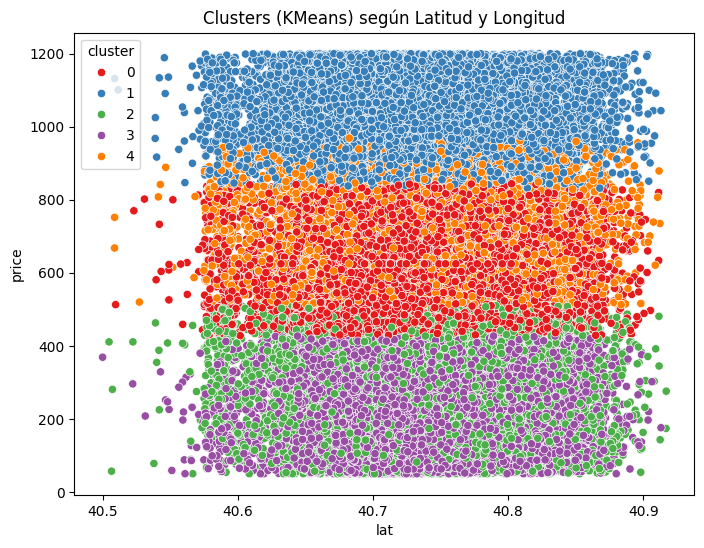

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['lat'], y=df['price'], hue=df['cluster'], data=df, palette='Set1')
plt.title('Clusters (KMeans) según Latitud y Longitud')
plt.show()

In [ ]:
numerical_cols

Index(['lat', 'long', 'construction_year', 'price', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'review_rate_number', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [ ]:
df_clus = df[numerical_cols]
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_clus)
    silhouette_scores.append(silhouette_score(df_clus, clusters))

# Visualizar resultados
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Análisis de número óptimo de clusters')
plt.show()

KeyboardInterrupt: 

In [ ]:
df_clus

## Division de los datos

In [ ]:

X= df.drop('price', axis=1)
y= df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_numeric = X_train[numeric_features].fillna(0)
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_numeric, y_train)
cols_selected = X_numeric.columns[selector.get_support()]
print("\nVariables numéricas seleccionadas (SelectKBest para regresión):", list(cols_selected))

In [ ]:
X_train_skb = X_numeric[cols_selected]
X_test_skb = X_test[cols_selected]

In [ ]:
X_test_skb.info()

In [ ]:
df_resultados = pd.DataFrame(columns=['Modelo', 'Preprocesado', 'R2', 'MAE', 'RMSE', 'MAPE'])

In [ ]:
def calculate(preprocessor_name, X_train, X_test, y_train, y_test):
    models = {
        'LinearRegression': LinearRegression(),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42)
   }
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df_resultados.loc[len(df_resultados)] = [model_name, preprocessor_name, r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred),root_mean_squared_error(y_test, y_pred),mean_absolute_percentage_error(y_test, y_pred)]
    
    return df_resultados.sort_values('R2', ascending=False)

In [ ]:
calculate('Sin preprocesado', X_train, X_test, y_train, y_test)


In [ ]:
calculate('Con SelectKBest', X_train_skb, X_test_skb, y_train, y_test)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_skb)
X_test_scaled = scaler.transform(X_test_skb)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_skb.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_skb.columns)

In [ ]:
calculate('MinMaxScaler + skb', X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [ ]:
calculate('MinMaxScaler', X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
# model = RandomForestRegressor(random_state=42)

# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'criterion': ['squared_error', 'absolute_error']
# }

# grid = GridSearchCV(model, params, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'], refit='neg_mean_absolute_error', verbose=1) # cv=5 por defecto
# grid.fit(X, y)


![alt text](<Captura de pantalla 2025-02-21 104437.png>)

In [ ]:
transformed = PowerTransformer()
X_train_tran = transformed.fit_transform(X_train_skb)
X_test_tran = transformed.transform(X_test_skb) 
X_train_tran = pd.DataFrame(X_train_tran, columns=X_train_skb.columns)
X_test_tran = pd.DataFrame(X_test_tran, columns=X_train_skb.columns)
X_train_tran.head(2)

In [ ]:
calculate('PowerTransformer', X_train_tran, X_test_tran, y_train, y_test)

In [ ]:
print('skew antes: \n', X_train_skb.skew())
print('skew después: \n', X_train_tran.skew())

* Validación cruzada

In [ ]:
model = LinearRegression()
results = cross_validate(model, X_train, y_train, 
               scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
)
print('fit_time', results['fit_time'].mean())
print('score_time', results['score_time'].mean())
print('test_r2', results['test_r2'].mean())
print('test_neg_mean_absolute_error', results['test_neg_mean_absolute_error'].mean())
print('test_neg_mean_squared_error', results['test_neg_mean_squared_error'].mean())
print('test_neg_mean_absolute_percentage_error', results['test_neg_mean_absolute_percentage_error'].mean())
print('test_neg_root_mean_squared_error', results['test_neg_root_mean_squared_error'].mean())

In [ ]:
X= X_train
y= y_train
models = {
    'LogisticRegression': LinearRegression(n_jobs=10),
    'KNN': KNeighborsRegressor(),
    'DT': DecisionTreeRegressor(),
    'SVC': SVR(),
    'RandomForest': RandomForestRegressor()
}

df_list = []
for name, model in models.items(): 
    
    results = cross_validate(model, X_train, y_train, cv=5, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'])
    df_model = pd.DataFrame(results)
    df_model['modelo'] = name
    df_list.append(df_model)

df_resultados = pd.concat(df_list, ignore_index=True)

In [ ]:
df_resultados

In [ ]:
df_pivot = df_resultados.groupby('modelo').mean().sort_values('test_r2', ascending=False)
df_pivot

In [ ]:
df_resultados_times = df_resultados[['modelo', 'fit_time', 'score_time']]
df_resultados_scores = df_resultados[['modelo', 'test_r2', 'test_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'test_neg_mean_absolute_percentage_error', 'test_neg_root_mean_squared_error']]

In [ ]:
# DATAFRAMES DE TIMES
df_times = df_resultados_times.melt(id_vars='modelo', var_name='time_type', value_name='time_seconds')
df_times.head(3)

In [ ]:
# DATAFRAMES DE SCORES
df_scores = df_resultados_scores.melt(id_vars='modelo', var_name='metric', value_name='score')
df_scores.head(3)

In [ ]:
# BOXPLOT PARA TIMES
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 18))
sns.boxplot(df_times, x='time_seconds', y='time_type', hue='modelo');

In [ ]:
plt.figure(figsize=(12, 4))
sns.boxplot(df_scores, x='score', y='metric', hue='modelo');

# Clasificación

In [ ]:
df_cla['instant_bookable'] = df_cla['instant_bookable'].astype('int')
df_e = df_cla.drop('room_type', axis=1)
df_room = df_cla['room_type']
df_cla.head()

* Encoder

In [ ]:
numerical_columns = df_e.select_dtypes(exclude=['object', 'category']).columns.to_list() # np.number alternativa
categorical_columns = df_e.select_dtypes(include=['object', 'category']).columns.to_list()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
df_encoded = encoder.fit_transform(df_e[categorical_columns]) 

df = pd.concat(
    [
        pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out()).reset_index(drop=True), # categoricas
        df_e[numerical_columns].reset_index(drop=True),
        df_room.reset_index(drop=True)
    ],
    axis=1
)
df.info()

In [ ]:
sns.countplot(df, x='room_type')

## Division de los datos

In [ ]:
X= df.drop('room_type', axis=1)
y= df['room_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [ ]:
print('Tamaño X_train', X_train.shape)
print('Distribución clases train:', Counter(y_train))
print('Tamaño X_test', X_test.shape)
print('Distribución clases test:', Counter(y_train))

In [ ]:
df_resultados = pd.DataFrame(columns=['Modelo', 'accuracy', 'precision', 'recall', 'f1', 'AUC'])

def calculate_metrics(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    df_resultados.loc[len(df_resultados)] = [name, accuracy, precision, recall, f1, auc]

In [ ]:
model = LogisticRegression(max_iter=10000, random_state=42)
calculate_metrics('Rlog', model, X_train, X_test, y_train, y_test)
df_resultados

In [ ]:
pca = PCA(n_components=10)
pca.fit(X_train)
varianza = np.cumsum(pca.explained_variance_ratio_)
print('varianza en cada componente', pca.explained_variance_ratio_)
print('varianza acumulada',varianza)

In [ ]:
plt.plot(range(1, len(varianza) + 1), varianza, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title('Método del codo para elegir n_components para PCA')
plt.xticks(range(1, len(varianza) + 1))
plt.grid()

In [ ]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train) 
X_test_pca = pca.transform(X_test)

In [ ]:
import plotly.express as px

px.scatter_3d(
    x=X_train_pca[:, 0], # componente principal 1
    y=X_train_pca[:, 1], # componente principal 2
    z=X_train_pca[:, 2], # componente principal 3
    color=y_train,
    color_continuous_scale='viridis',
    title='PCA 3D iris',
    labels={
        'x': 'componente principal 1',
        'y': 'componente principal 2',
        'z': 'componente principal 3'
    }
)

In [ ]:
model = LogisticRegression(max_iter=5000)
calculate_metrics('Rlog PCA', model, X_train_pca, X_test_pca, y_train, y_test)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Tamaño X_train', X_train.shape)
print('Distribución clases y_train:', Counter(y_train))

print('\nTamaño X_train_resampled', X_train_smote.shape)
print('Distribución clases y_train_resampled:', Counter(y_train_smote))

In [ ]:
model = LogisticRegression(max_iter=5000)
calculate_metrics('Rlog Smote', model, X_train_smote, X_test, y_train_smote, y_test)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

print('Tamaño X_train', X_train_pca.shape)
print('Distribución clases y_train:', Counter(y_train))

print('\nTamaño X_train_resampled', X_train_smote.shape)
print('Distribución clases y_train_resampled:', Counter(y_train_smote))

In [ ]:
model = LogisticRegression(max_iter=5000)
calculate_metrics('Rlog Smote PCA', model, X_train_smote, X_test_pca, y_train_smote, y_test)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
model = KNeighborsClassifier()
calculate_metrics('KNN 5', model, X_train, X_test, y_train, y_test)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
model = DecisionTreeClassifier()
calculate_metrics('DTC', model, X_train, X_test, y_train, y_test)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
model = RandomForestClassifier()
calculate_metrics('RFC', model, X_train, X_test, y_train, y_test)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
# model = SVC(probability=True)
# calculate_metrics('SVC', model, X_train, X_test, y_train, y_test)
# df_resultados

Comentado porque tarda mucho
![alt text](image-1.png)


* Validación cruzada

In [ ]:
from sklearn.model_selection import cross_val_score


model = LogisticRegression(max_iter=5000, random_state=42)
results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print('accuracy cv', results.mean())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('accuracy test', accuracy_score(y_test, y_pred))

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DTC': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

df_list = []
for name, model in models.items(): 
    
    results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr'])
    df_model = pd.DataFrame(results)
    df_model['modelo'] = name
    df_list.append(df_model)

df_resultados = pd.concat(df_list, ignore_index=True)
df_resultados.sort_values('accuracy', ascending=False)

In [ ]:
df_pivot = df_resultados.groupby('modelo').mean().sort_values('test_f1_macro', ascending=False)
df_pivot

In [ ]:
sns.heatmap(df_pivot.drop(columns=['fit_time','score_time']), annot=True, cmap='viridis')

In [ ]:
# dividir en dos dataframes, unos para times y otro para scores
df_resultados_times = df_resultados[['modelo', 'fit_time', 'score_time']]
df_resultados_scores = df_resultados[['modelo', 'test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc_ovr']]

In [ ]:
# DATAFRAMES DE TIMES
df_times = df_resultados_times.melt(id_vars='modelo', var_name='time_type', value_name='time_seconds')
df_times.head(3)

In [ ]:
# DATAFRAMES DE SCORES
df_scores = df_resultados_scores.melt(id_vars='modelo', var_name='metric', value_name='score')
df_scores.head(3)

In [ ]:
# BOXPLOT PARA TIMES
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 18))
sns.boxplot(df_times, x='time_seconds', y='time_type', hue='modelo');

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(df_scores, x='metric', y='score', hue='modelo');

# Pipelines

## Regresion

In [ ]:
df = pd.read_csv('airbnb_nyc_clean.csv')
df = df.drop(['id','name','host_id','host_name','last_review', 'house_rules'], axis=1)
numerical_col = df.select_dtypes(include=[np.number]).columns
categorical_col = df.select_dtypes(exclude=[np.number]).columns
df_cla = df.copy()

In [ ]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
df_resultados = pd.DataFrame(columns=['Modelo','R2', 'MAE', 'RMSE', 'MAPE'])

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])

pipeline_numerical = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_col),
    ('categorical', pipeline_categorical, categorical_col)
])
pipeline = Pipeline([
    ('pipeline', pipeline_all),
    ('modelo', LinearRegression())]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
df_resultados.loc[len(df_resultados)] = [f'LR ', r2, mae, rmse, mape]

df_resultados

In [ ]:
escaladores = {
    'None' : None,
    'StandarS':StandardScaler(),
    'MinMaxS':MinMaxScaler(),
    'RobustS':RobustScaler(),
}

transformadores = {
    'None' : None,
    'PowerT':PowerTransformer(),
    'QuantileT':QuantileTransformer()
}

modelos = {
    'LR' : LinearRegression(),
    'KNN' : KNeighborsRegressor(),
    'CART' : DecisionTreeRegressor(random_state=42),
}

In [ ]:
df_resultados = pd.DataFrame(columns=['Modelo','R2', 'MAE', 'RMSE', 'MAPE'])

pipeline_categorical = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
            ])
for nombre_escalador, escalador in escaladores.items():
    for nombre_modelo, modelo in modelos.items():
        for nombre_transformador, transformador in transformadores.items():
            if escalador == None and transformador != None:
                pass
            else:
                pipeline_numerical = Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                    ('scaler', escalador),
                    ('transformer', transformador),
                ])
                pipeline_all = ColumnTransformer([
                    ('numeric', pipeline_numerical, numerical_col),
                    ('categorical', pipeline_categorical, categorical_col)
                ])
                pipeline = Pipeline([
                    ('pipeline', pipeline_all),
                    ('modelo', modelo)]
                )
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                rmse = root_mean_squared_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)
                df_resultados.loc[len(df_resultados)] = [f'{nombre_escalador} {nombre_transformador} {nombre_modelo}', r2, mae, rmse, mape]
                print(f'{nombre_escalador} {nombre_transformador} {nombre_modelo}')
        
df_resultados.sort_values('R2', ascending=False)